In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile
import tempfile
import numpy as np
from PIL import Image
import tensorflow as tf
from pathlib import Path
from shutil import copyfile
from skimage import exposure
from skimage.feature import hog
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_archive_path = "/content/drive/My Drive/Colab Notebooks/GigaChallenge/datasets/hog_features_256x256.zip"
path_to_extract_archive = tempfile.gettempdir()
path_to_dirs_for_model_training = os.path.join(tempfile.gettempdir(), "data")
#image_classes_dir_path = os.path.join(path_to_extract_archive, "datasets")
image_classes_dir_path = os.path.join(path_to_extract_archive, "hog_features")
dirs_for_model_training = ["train", "val", "test"]
SEED_NUM = 51

def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def create_folders(paths):
  _ = [Path(p).mkdir(parents=True, exist_ok=True) for p in paths]

def copy_files(files, src_dir, dest_dir):
  _ = [copyfile(os.path.join(src_dir, f), os.path.join(dest_dir, f))
       for f in files]

def copy_files_for_model_training(image_classes_dir_path, train_dir, val_dir, test_dir, num_files):
  for class_name in os.listdir(image_classes_dir_path):
    path = os.path.join(image_classes_dir_path, class_name)
    if os.path.isdir(path):
      train_ds, val_ds, test_ds = split_data(path, total_images=num_files)
      _ = [copy_files(ds, path, dest) for ds, dest in [(train_ds, os.path.join(train_dir, class_name)),
                                                      (val_ds, os.path.join(val_dir, class_name)),
                                                      (test_ds, os.path.join(test_dir, class_name))]]
def is_valid_image(parent_dir, fname):
  path = os.path.join(parent_dir, fname)
  try:
    img = Image.open(path)
    img.verify()
  except Exception as e:
    print(f"Invalid image: {path}")
    return False
  return True

def get_dataset_size(image_classes_dir_path):
  dataset_size = sys.maxsize
  for d in os.listdir(image_classes_dir_path):
    imgs_path = os.path.join(image_classes_dir_path, d)
    if os.path.isdir(imgs_path):
      files_num = len([f for f in os.listdir(imgs_path) if is_valid_image(imgs_path, f)])
      dataset_size = min(dataset_size, files_num)
  return dataset_size

def split_data(images_dir, train_pct = 0.75, val_pct = 0.15, total_images=None):
  imgs = os.listdir(images_dir)
  valid_imgs = []
  for img_name in imgs:
    try:
      img_path = os.path.join(images_dir, img_name)
      img = Image.open(img_path)
      img.verify()
      valid_imgs.append(img_name)
    except Exception as e:
      print(f"Invalid image: {img_path}")
  n_images = total_images if total_images else len(valid_imgs)
  print(f"n_images: {n_images}")
  n_train_images = round(n_images * train_pct)
  n_val_images = round(n_images * val_pct)
  print(f"valid_imgs: {len(valid_imgs)}")
  print(f"n_train_images: {n_train_images}")
  print(f"n_val_images: {n_val_images}")
  print(f"n_images: {n_images}")
  train_images = valid_imgs[:n_train_images]
  val_images = valid_imgs[n_train_images:n_train_images+n_val_images]
  test_images = valid_imgs[n_train_images+n_val_images:n_images]
  return train_images, val_images, test_images

def extract_archive(archive_path, dest_dir):
  if not os.path.exists(archive_path):
    raise Exception(f"Archive {archive_path} does not exist.")
  create_folders([ dest_dir ])
  zip_ref = zipfile.ZipFile(archive_path, "r")
  zip_ref.extractall(dest_dir)
  zip_ref.close()

def create_dirs_for_model_training(base_path, image_classes_dir_path):
  train_dir, val_dir, test_dir = [os.path.join(base_path, d) for d in ["train", "val", "test"]]
  for class_name in os.listdir(image_classes_dir_path):
    sub_folders = [os.path.join(d, class_name) for d in [train_dir, val_dir, test_dir]]
    create_folders(sub_folders)
  return train_dir, val_dir, test_dir

class AccuracyCallback(Callback):
  def __init__(self, target_acc_pct):
    self.target_acc_pct = target_acc_pct
  def on_epoch_end(self, epoch, logs={}):
    current_acc_pct = logs.get("binary_accuracy")
    if current_acc_pct >= self.target_acc_pct:
      current_acc = round(current_acc_pct*100, 2)
      target_acc = round(self.target_acc_pct*100, 2)
      print(f"\nCurrent accuracy is {current_acc}, target accuracy of {target_acc} is reached.\n")
      self.model.stop_training=True

class F1Metrics(Callback):
    def on_epoch_end(self, batch, logs={}):
        print(self.validation_data)
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        self.f1s=f1_score(targ, predict)
        return

def get_model():
  model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation="relu", input_shape=(256, 256, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="relu"),
    #Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25),
    Dense(1, activation="sigmoid")  
  ])
  model.summary()
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=10e-5),
                #optimizer=Adam(learning_rate=0.00001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[BinaryAccuracy(),
                         tf.keras.metrics.AUC(),
                         tf.keras.metrics.Precision(),
                         tf.keras.metrics.Recall()])
  """
  model.compile(loss="binary_crossentropy",
                optimizer=Adam(learning_rate=0.0001),
                metrics=[BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precission])
  """
  return model

def get_image_generator(images_dir, **kwargs):
  datagen = ImageDataGenerator(**kwargs)
  generator = datagen.flow_from_directory(images_dir, batch_size=32, class_mode="binary", color_mode="grayscale")
  return generator

Mounted at /content/drive


In [ ]:
extract_archive(dataset_archive_path, path_to_extract_archive)

In [ ]:
import sys

set_seed(SEED_NUM)
train_dir, val_dir, test_dir = create_dirs_for_model_training(path_to_dirs_for_model_training, image_classes_dir_path)
print(train_dir, val_dir, test_dir)
ds_size = get_dataset_size(image_classes_dir_path)
print(ds_size)
copy_files_for_model_training(image_classes_dir_path, train_dir, val_dir, test_dir, ds_size)

#copy_files(training_imgs, imgs_src_dir, training_imgs_dir)
#copy_files(test_imgs, imgs_src_dir, test_imgs_dir)
#train_images, val_images, test_images = split_data()

/tmp/data/train /tmp/data/val /tmp/data/test
5248
n_images: 5248
valid_imgs: 5248
n_train_images: 3936
n_val_images: 787
n_images: 5248
n_images: 5248
valid_imgs: 5248
n_train_images: 3936
n_val_images: 787
n_images: 5248


In [ ]:
!ls /tmp/data/train/school | wc -l
!ls /tmp/data/val/school | wc -l
!ls /tmp/data/test/school | wc -l
!ls /tmp/data/train/non_school | wc -l
!ls /tmp/data/val/non_school | wc -l
!ls /tmp/data/test/non_school | wc -l

3936
787
525
3936
787
525


In [ ]:
model = get_model()
train_opts = dict(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    rotation_range=40,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
train_data_generator = get_image_generator(train_dir, **train_opts)
val_data_generator = get_image_generator(val_dir)
test_data_generator = get_image_generator(test_dir)
      

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [ ]:
history = model.fit(
    train_data_generator,
    validation_data = val_data_generator,
#    steps_per_epoch=150,
#    validation_steps=30,
#    epochs=10,
    steps_per_epoch=150,
    validation_steps=30,
    epochs=100,
    #callbacks=[AccuracyCallback(target_acc_pct=0.95),
    #           EarlyStopping(monitor='binary_accuracy', patience=3)],
    callbacks=[EarlyStopping(monitor='recall', patience=10),
               EarlyStopping(monitor='precision', patience=10)],
    verbose=2
)

Epoch 1/100
150/150 - 48s - loss: 0.8984 - binary_accuracy: 0.5735 - auc: 0.5936 - precision: 0.5741 - recall: 0.5901 - val_loss: 1.0772 - val_binary_accuracy: 0.5063 - val_auc: 0.8089 - val_precision: 0.5011 - val_recall: 1.0000 - 48s/epoch - 318ms/step
Epoch 2/100
150/150 - 37s - loss: 0.5706 - binary_accuracy: 0.7171 - auc: 0.7768 - precision: 0.7063 - recall: 0.7359 - val_loss: 0.6536 - val_binary_accuracy: 0.6844 - val_auc: 0.8649 - val_precision: 0.6130 - val_recall: 0.9895 - 37s/epoch - 246ms/step
Epoch 3/100
150/150 - 36s - loss: 0.5279 - binary_accuracy: 0.7460 - auc: 0.8150 - precision: 0.7223 - recall: 0.7935 - val_loss: 0.7269 - val_binary_accuracy: 0.6354 - val_auc: 0.8589 - val_precision: 0.5780 - val_recall: 0.9916 - 36s/epoch - 243ms/step
Epoch 4/100
150/150 - 37s - loss: 0.5101 - binary_accuracy: 0.7429 - auc: 0.8278 - precision: 0.7145 - recall: 0.7928 - val_loss: 0.4547 - val_binary_accuracy: 0.7844 - val_auc: 0.8922 - val_precision: 0.7203 - val_recall: 0.9149 - 37s

{'loss': [0.8984279632568359, 0.5705751180648804, 0.5278728008270264, 0.5100952982902527, 0.5006242990493774, 0.49303218722343445, 0.48562419414520264, 0.4777016341686249, 0.4674321413040161, 0.4586806297302246, 0.46719878911972046], 'binary_accuracy': [0.5735416412353516, 0.7170833349227905, 0.7460416555404663, 0.7429166436195374, 0.7631250023841858, 0.768958330154419, 0.7712500095367432, 0.7745833396911621, 0.7864583134651184, 0.7941666841506958, 0.7866666913032532], 'auc': [0.5936002731323242, 0.776809573173523, 0.8150205612182617, 0.8277968764305115, 0.8374843001365662, 0.8407689332962036, 0.846174418926239, 0.8511486649513245, 0.860314667224884, 0.8626181483268738, 0.859375536441803], 'precision': [0.5741337537765503, 0.7062852382659912, 0.7223070859909058, 0.7145044207572937, 0.7386191487312317, 0.7397416234016418, 0.7446966767311096, 0.7486095428466797, 0.761904776096344, 0.7625468373298645, 0.7605363726615906], 'recall': [0.590062141418457, 0.735936164855957, 0.7935375571250916

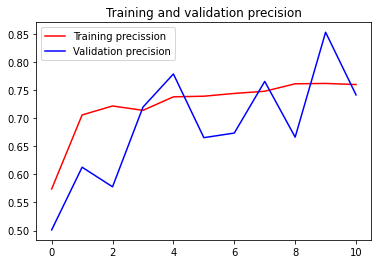

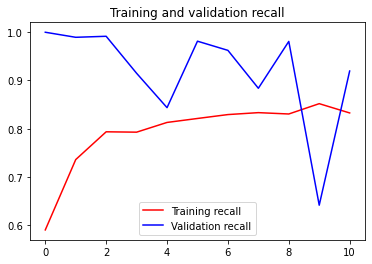

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

print(history)
print(history.history)

prec = history.history['precision']
recall = history.history['recall']
val_prec = history.history['val_precision']
val_recall = history.history['val_recall']

epochs = range(len(prec))

plt.figure()
plt.plot(epochs, prec, 'r', label = 'Training precission')
plt.plot(epochs, val_prec, 'b', label = 'Validation precision')
plt.title('Training and validation precision')
plt.legend(loc = 0)
plt.figure()
plt.plot(epochs, recall, 'r', label = 'Training recall')
plt.plot(epochs, val_recall, 'b', label = 'Validation recall')
plt.title('Training and validation recall')
plt.legend(loc = 0)

plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

def predict(model, uploaded_files):
  for fn in uploaded_files.keys():
    path = '/content/' + fn
    img = image.load_img(path)
    x = image.img_to_array(img)
    fd, hog_image = hog(x, orientations=9, pixels_per_cell=(2, 2),
                      cells_per_block=(4, 4), visualize=True, multichannel=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 50))
    x = np.expand_dims(hog_image_rescaled, axis = 0)
    images = np.vstack([x])
    print(images.shape)
    classes = model.predict(images, batch_size = 10)
    if (classes[0] > 0.5):
      print(fn + ' is a school')
    else:
      print(fn + ' is a non-school')

uploaded_files = files.upload()
predict(model, uploaded_files)

Saving 51402333_W.png to 51402333_W.png
(1, 256, 256)
51402333_W.png is a non-school


In [ ]:
!rm -rf /tmp/data/